<a href="https://colab.research.google.com/github/KodyKendall/mit-deeplearning-2024/blob/main/KODY_KENDALL_FACE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "IC7gAAkfN683SpE7WjRo1pcRc"

# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.8/586.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 [==============================] - 13s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

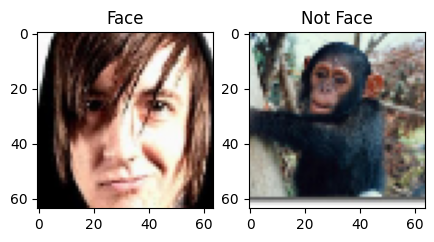

In [4]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 15 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [5]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [6]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name=project_name)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment


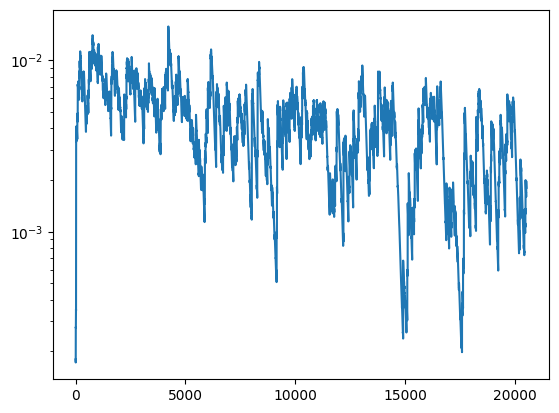

100%|██████████| 3434/3434 [00:52<00:00, 65.97it/s]


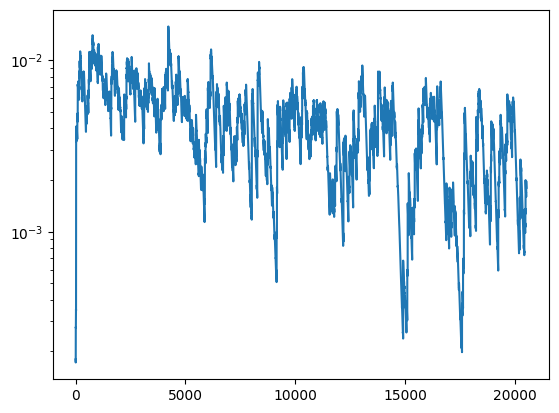

In [26]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  # num_epochs = 2,  # keep small to run faster
  num_epochs = 6,  # (increasing now so I can try to get it to be more accurate)
  learning_rate = 5e-4,
)

experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(params["batch_size"])
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [33]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 0s 2ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9998


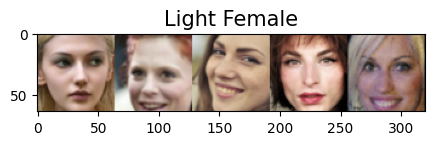

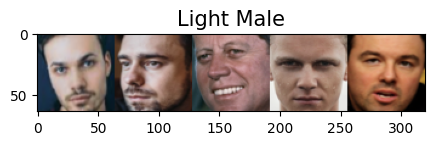

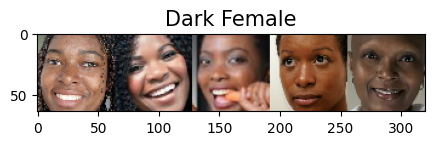

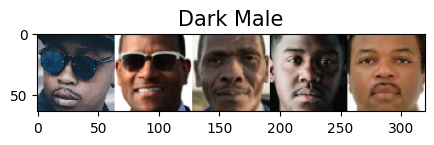

In [28]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces() #get test faces.. what is this exactly?
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group)) #hstack..? what is that.? OH, it's flattening this and taking the raw image data as pixels and feeding it through to display.
  plt.title(key, fontsize=15)

In [71]:
### Evaluation of DB_VAE ###

# TESTING DATA
# Evaluate on our brand new set of faces that our Celeb-Net didn't train on.

#Our test faces data has categories as it's first dimension, so we reshape the data to remove the categories and squeeze them all in.
test_faces_without_light_gender_categories = np.array(test_faces).reshape(-1, *np.array(test_faces).shape[2:])
y_faces = np.ones((len(test_faces_without_light_gender_categories), 1)) #all these new pictures are indeed faces, so we set them to 1

new_batch_x = test_faces_without_light_gender_categories
new_batch_y = y_faces

y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(new_batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(new_batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on the new set of faces, (non-celebrity dataset): {:.4f}".format(acc_standard.numpy()))

1/1 [==============================] - 0s 151ms/step
Standard CNN accuracy on the new set of faces, (non-celebrity dataset): 0.6500


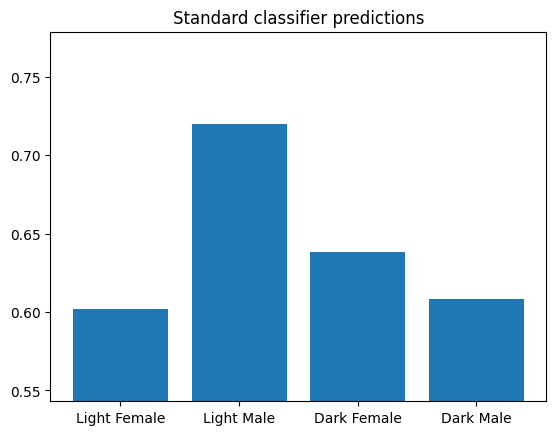

In [29]:
### Evaluate the standard CNN on the test data ###

#test_faces are 3D raw pixel arrays (images).
#so we're taking the raw pixel data and training on that.. interesting.
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits)) #this is a little confusing, not sure what shape our data is in or what type.

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

In [14]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon #TODO <- My Version
  # z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

In [15]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # print(mu.shape())
  # latent_loss = # TODO


  # TODO: Define the reconstruction loss as the mean absolute pixel-wise
  # difference between the input and reconstruction. Hint: you'll need to
  # use tf.reduce_mean, and supply an axis argument which specifies which
  # dimensions to reduce over. For example, reconstruction loss needs to average
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  # reconstruction_loss = # TODO



  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  # vae_loss = # TODO

  return vae_loss

In [16]:
"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  # total_loss = # TODO
  total_loss =  tf.reduce_mean(face_indicator * vae_loss + classification_loss)

  return total_loss, classification_loss

In [17]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables # --> what does this represent? number of features that we're tracking in the latent space?

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [18]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [19]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [20]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])

    # consider the distribution for each latent variable
    for i in range(latent_dim):

        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        # TODO: call the digitize function to find which bins in the latent distribution
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function
        p = 1.0/(hist_smoothed_density[bin_idx-1])

        # TODO: normalize all probabilities
        p = p / np.sum(p)
        # p = # TODO

        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO

    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 10/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

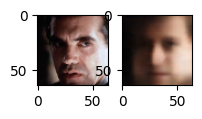

 14%|█▍        | 497/3434 [00:07<00:35, 82.45it/s]

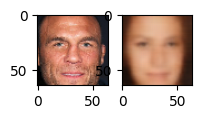

 29%|██▉       | 999/3434 [00:14<00:29, 82.37it/s]

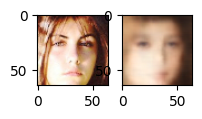

 44%|████▎     | 1496/3434 [00:23<00:24, 79.16it/s]

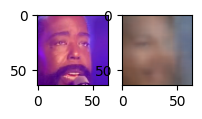

 58%|█████▊    | 1998/3434 [00:31<00:26, 54.65it/s]

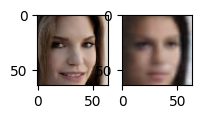

 73%|███████▎  | 2495/3434 [00:38<00:11, 78.28it/s]

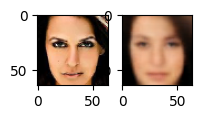

 87%|████████▋ | 3000/3434 [00:46<00:05, 77.38it/s]

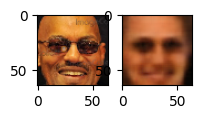

100%|██████████| 3434/3434 [00:53<00:00, 64.25it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kodykendall/6s191-lab2-part2-dbvae/4039678228f546ea9bb0051065faa075
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [34340] : (0.044124070554971695, 0.9308887124061584)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INF

In [74]:
### Training the DB-VAE ###

# Hyperparameters
params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  # num_epochs = 1, #DB-VAE needs slightly more epochs to train
  #num_epochs = 4, #Going to increase this to get more training time.
  num_epochs = 10, #Ok, that didn't work. Let's jump it up even higher to give it more time to train.


)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) #Idea: we could change the learning_rate and the latent_dimensions.

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):
  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    #TODO: We need to implement re-parameterization into the loss_function

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO

  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()

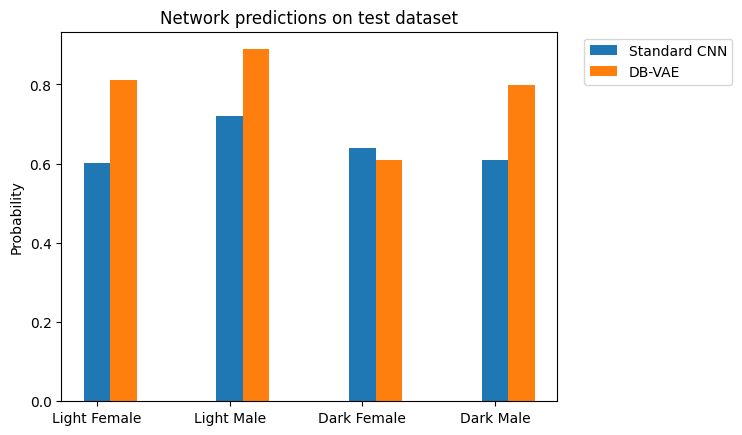

In [76]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys);
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");


In [ ]:
#Create a standalone graph for the DB-VAE model:
#test_faces are 3D raw pixel arrays (images).
#so we're taking the raw pixel data and training on that.. interesting.
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_classifier_logits = [dbvae.predict(np.array(x, dtype=np.float32))]
# standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits)) #this is a little confusing, not sure what shape our data is in or what type.
dbvae_classifier_probs =

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

In [77]:
### Test our accuracy of the DB_VAE ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
# print(len(batch_x))
# print(len(batch_y)) #how do I squeeze this into an array of zeros?
# breakpoint()

test_faces = mdl.lab2.get_test_faces() #get test faces.. what is this exactly?
dimensionality_of_test_faces = np.array(test_faces).shape #there's 4 categories, 5 pictures for each category, so there's 20 pictures total. I need to squeeze out the 4 categories so it's an array of (20, 64, 64, 3)
print(dimensionality_of_test_faces)

#we need to convert this into shape
test_faces_without_light_gender_categories = np.array(test_faces).reshape(-1, *np.array(test_faces).shape[2:])

number_of_test_face_pictures = len(test_faces_without_light_gender_categories) #gives us
# print("There are {0} test faces in our new dataset".format(number_of_test_face_pictures))
#test_faces_should_all_be_faces = #np.ones
y_faces = np.ones((number_of_test_face_pictures, 1))
# print(number_of_test_face_pictures)
# print(len(y_faces))

new_batch_x = test_faces_without_light_gender_categories
new_batch_y = y_faces

# print(number_of_test_faces)
# print(test_faces_without_light_gender_categories.shape)
# print(test_faces)

#I need to mesh all the test_faces together, and squeeze the 4 dimensions into a single dimension (I don't need the category for each one yet).
# I want to get overall accuracy for it.

# Reshaping the data to combine the first two dimensions
# The result will have the shape (20, 64, 64, 3)
# test_faces_without_light_gender_categories = test_faces.reshape(-1, *test_faces.shape[2:])

#TODO: I need an array of 1-dimensonal arrays with 1s in them that are the same size as batch_x

# y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(test_faces)))
# acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
# print(len(batch_x))
# print(len(batch_y)) #how do I squeeze this into an array of zeros?

(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(dbvae.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("DB_VAEN accuracy on CelebNet face images set: {:.4f}".format(acc_standard.numpy()))

y_pred_standard = tf.round(tf.nn.sigmoid(dbvae.predict(new_batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(new_batch_y, y_pred_standard), tf.float32))

print("DB_VAEN accuracy on new face images set: {:.4f}".format(acc_standard.numpy()))

(4, 5, 64, 64, 3)
DB_VAEN accuracy on CelebNet face images set: 0.9992
DB_VAEN accuracy on new face images set: 0.8000
